In [1]:
import matplotlib.pylab as plt
import random
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_io as tfio


print("TF version   : ", tf.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF version   :  2.10.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
SEED = 2748623542
BATCH_SIZE=16

In [3]:
from dataset import datasetSplit

train_files, validation_files, test_files = datasetSplit('slices_dicom/sagittal/*.dcm', seed=SEED)

# Preprocessing with tf.data

In [12]:
def augmentImage(image, label):
    with tf.device('/CPU:0'):
        #Noise and Dropout
        doDropout = tf.random.uniform(shape=[], minval=0, maxval=1)
        if doDropout < 0.3:
            dropoutRate = tf.random.uniform(shape=[], minval=0, maxval=0.04)
            image = tf.nn.dropout(image, dropoutRate)

        doNoise = tf.random.uniform(shape=[], minval=0, maxval=1)
        if doNoise < 0.3:
            noise = tf.random.uniform(shape=[], minval=0, maxval=0.04)
            image = tf.keras.layers.GaussianNoise(noise)(image, training=True)

        #Blankout and blur
        doCutout = tf.random.uniform(shape=[], minval=0, maxval=1)
        if doCutout < 0.3:
            minx = int(128 * 0.04 / 2)
            miny = int(128 * 0.04 / 2)
            maxx = int(128 * 0.24 / 2)
            maxy = int(128 * 0.24 / 2)

            sizex = tf.math.scalar_mul(2, tf.random.uniform(shape=[], minval=minx, maxval=maxx, dtype=tf.dtypes.int32))
            sizey = tf.math.scalar_mul(2, tf.random.uniform(shape=[], minval=miny, maxval=maxy, dtype=tf.dtypes.int32))
            fill = tf.random.uniform(shape=[], minval=0, maxval=1)

            image = tfa.image.random_cutout(image, mask_size=(sizex, sizey), constant_values=fill)

        doBlur = tf.random.uniform(shape=[], minval=0, maxval=1)
        if doBlur < 0.3:
            image = tfa.image.gaussian_filter2d(image, filter_shape=[3, 3], sigma=0.6, constant_values=0)

    return image, label

def getImage(file_path: tf.Tensor, input_size, output_size):
    with tf.device('/CPU:0'):
        image = tf.io.read_file(file_path)
        image = tfio.image.decode_dicom_image(image, color_dim=True, on_error='strict', dtype=tf.float32)[0]
        image /= (2**32 - 1)

        label = tf.image.resize(image, size=output_size)
        image = tf.image.resize(image, size=input_size)

    return image, label

def createDataset(fileList, batch_size, input_size=(128, 128), output_size=(128, 128), seed=None, shuffle=False, augment=False, buffer_size=None, sample=None):
    with tf.device('/CPU:0'):
        if seed != None:
            tf.random.set_seed(seed)

        if sample != None:
            fileList = random.sample(fileList, sample)
        ds = tf.data.Dataset.from_tensor_slices(fileList)
        ds = ds.map(lambda x: tf.py_function(func=getImage, inp=[x, input_size, output_size], Tout=(tf.float32, tf.float32)), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.cache()
        if buffer_size == None:
            buffer_size = len(fileList)
        if shuffle:
            ds = ds.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
        ds = ds.batch(batch_size)
        if augment:
            ds = ds.map(lambda image, label: tf.py_function(func=augmentImage, inp=[image, label], Tout=(tf.float32, tf.float32)), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


# Benchmark of the Dataset

In [32]:
tfds.benchmark(createDataset(train_files, 16), batch_size=16)


************ Summary ************



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2576/2576 [02:48<00:00, 15.26it/s]


Examples/sec (First included) 244.26 ex/sec (total: 41232 ex, 168.80 sec)
Examples/sec (First only) 212.16 ex/sec (total: 16 ex, 0.08 sec)
Examples/sec (First excluded) 244.27 ex/sec (total: 41216 ex, 168.73 sec)


,duration,num_examples,avg
first+lasts,168.804396,41232,244.259042
first,0.075413,16,212.163605
lasts,168.728982,41216,244.273387


In [33]:
tfds.benchmark(createDataset(train_files, 16, shuffle=True), batch_size=16)


************ Summary ************



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2576/2576 [02:55<00:00, 14.64it/s]


Examples/sec (First included) 234.30 ex/sec (total: 41232 ex, 175.98 sec)
Examples/sec (First only) 0.09 ex/sec (total: 16 ex, 174.64 sec)
Examples/sec (First excluded) 30705.75 ex/sec (total: 41216 ex, 1.34 sec)


,duration,num_examples,avg
first+lasts,175.982574,41232,234.295925
first,174.640285,16,0.091617
lasts,1.342289,41216,30705.745668


In [34]:
tfds.benchmark(createDataset(train_files, 16, augment=True), batch_size=16)


************ Summary ************



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2576/2576 [03:15<00:00, 13.16it/s]


Examples/sec (First included) 210.62 ex/sec (total: 41232 ex, 195.77 sec)
Examples/sec (First only) 38.75 ex/sec (total: 16 ex, 0.41 sec)
Examples/sec (First excluded) 210.98 ex/sec (total: 41216 ex, 195.35 sec)


,duration,num_examples,avg
first+lasts,195.767364,41232,210.617332
first,0.412954,16,38.745217
lasts,195.354410,41216,210.980648


In [35]:
tfds.benchmark(createDataset(train_files, 16, shuffle=True, augment=True), batch_size=16)


************ Summary ************



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2576/2576 [03:39<00:00, 11.75it/s]


Examples/sec (First included) 188.00 ex/sec (total: 41232 ex, 219.32 sec)
Examples/sec (First only) 0.09 ex/sec (total: 16 ex, 185.48 sec)
Examples/sec (First excluded) 1217.85 ex/sec (total: 41216 ex, 33.84 sec)


,duration,num_examples,avg
first+lasts,219.324252,41232,187.995626
first,185.481063,16,0.086262
lasts,33.843189,41216,1217.852125


# Sample augmented images, next to ground thruth

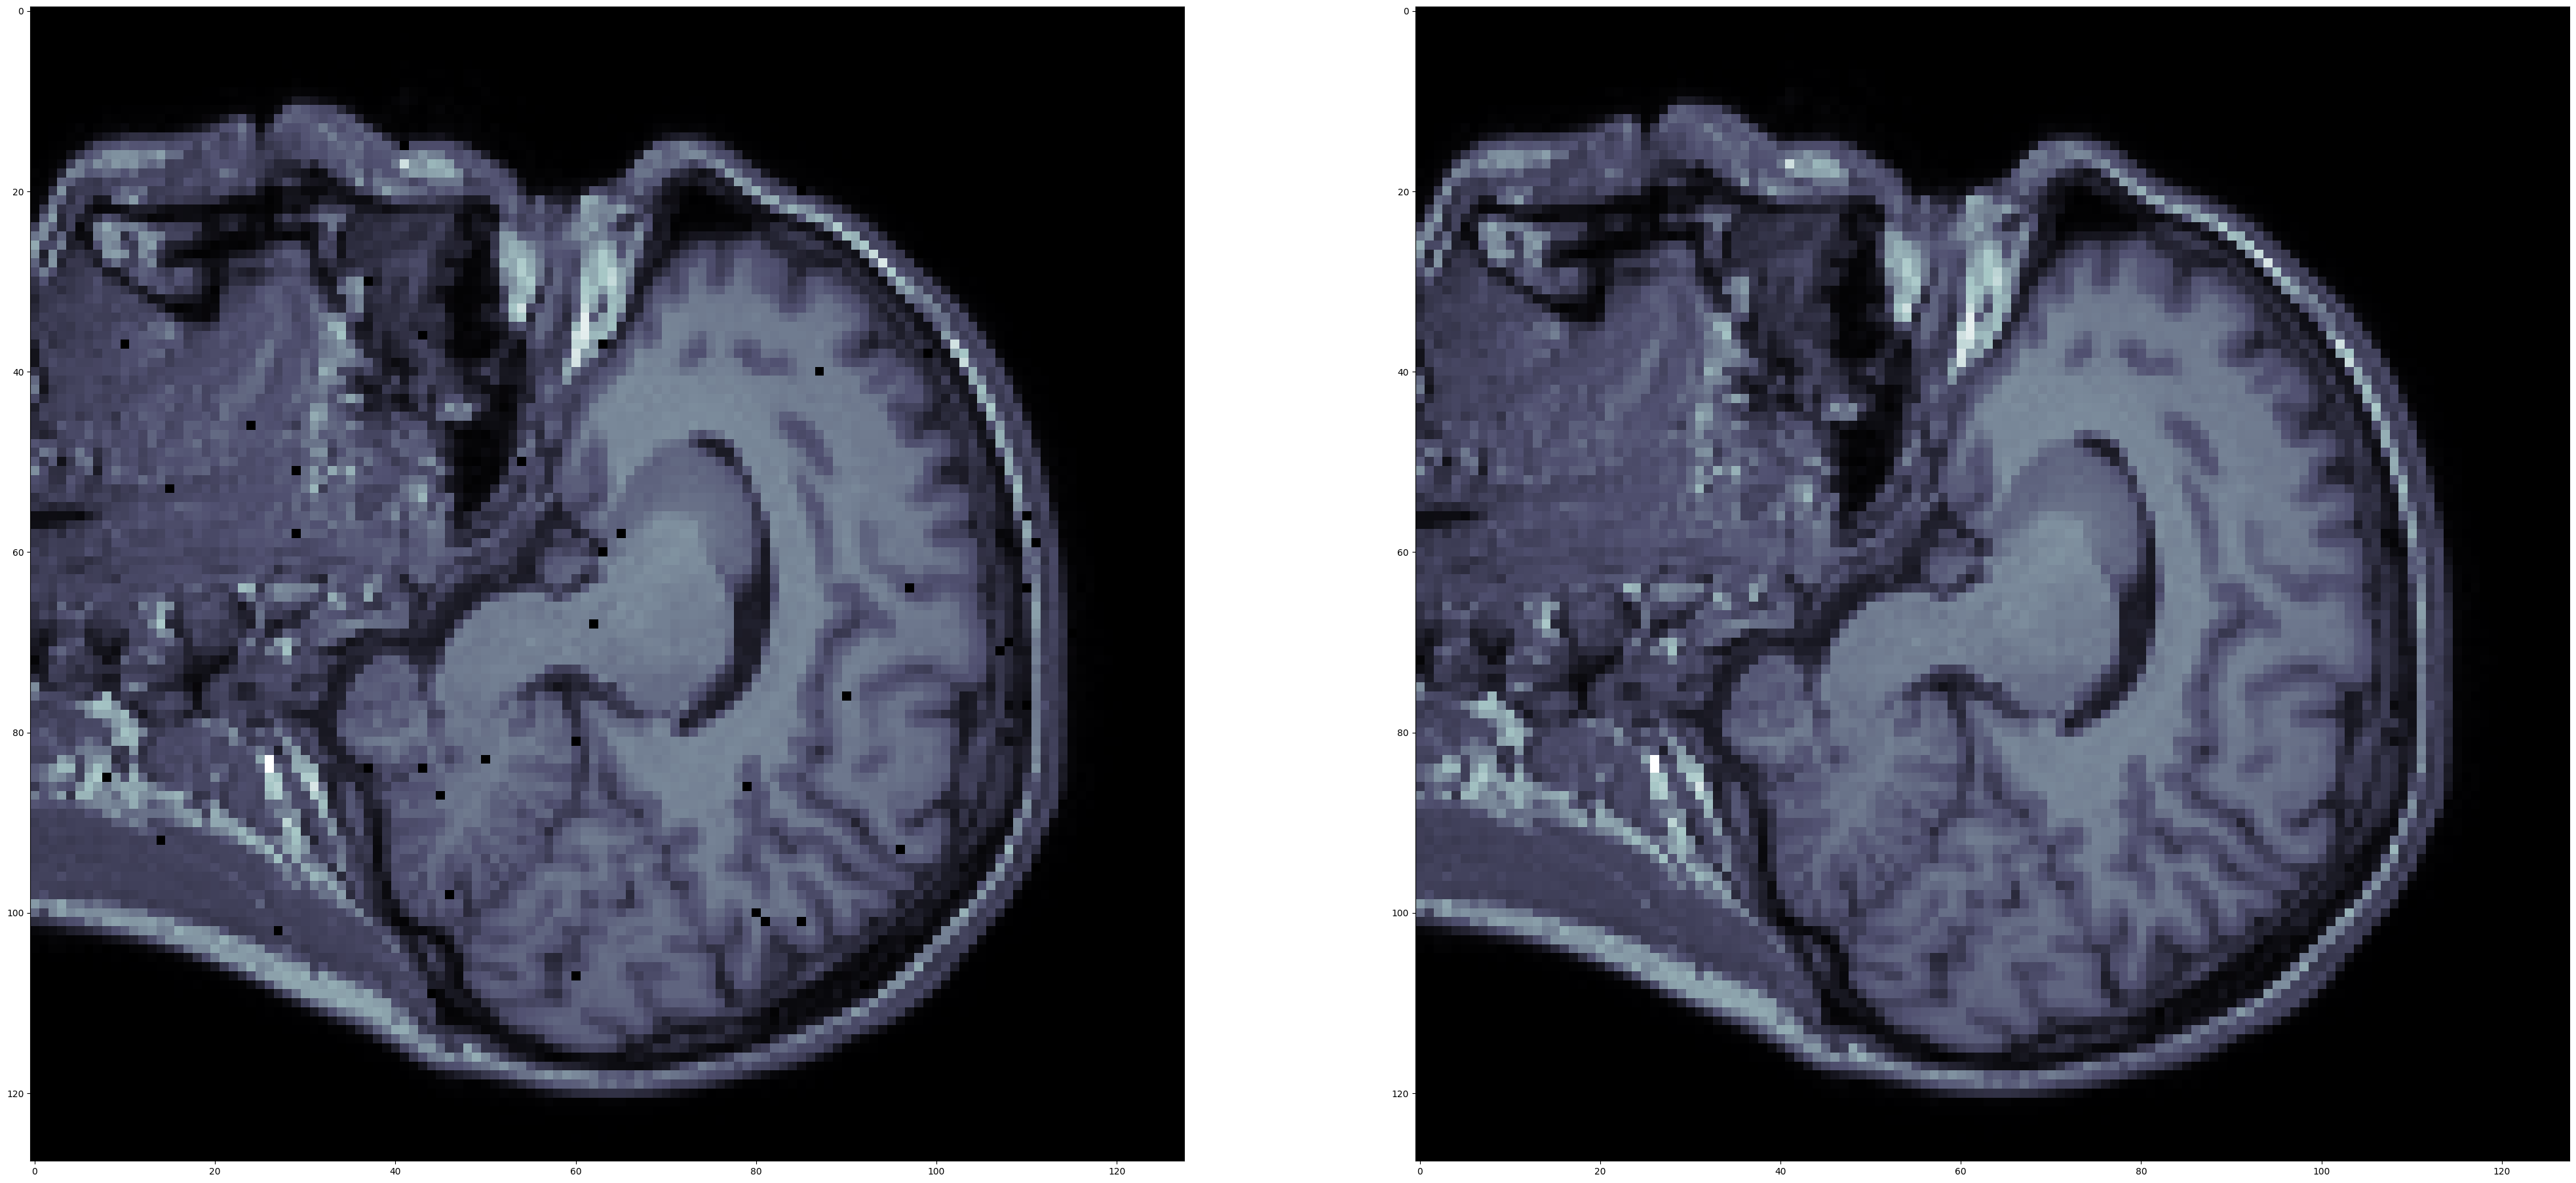

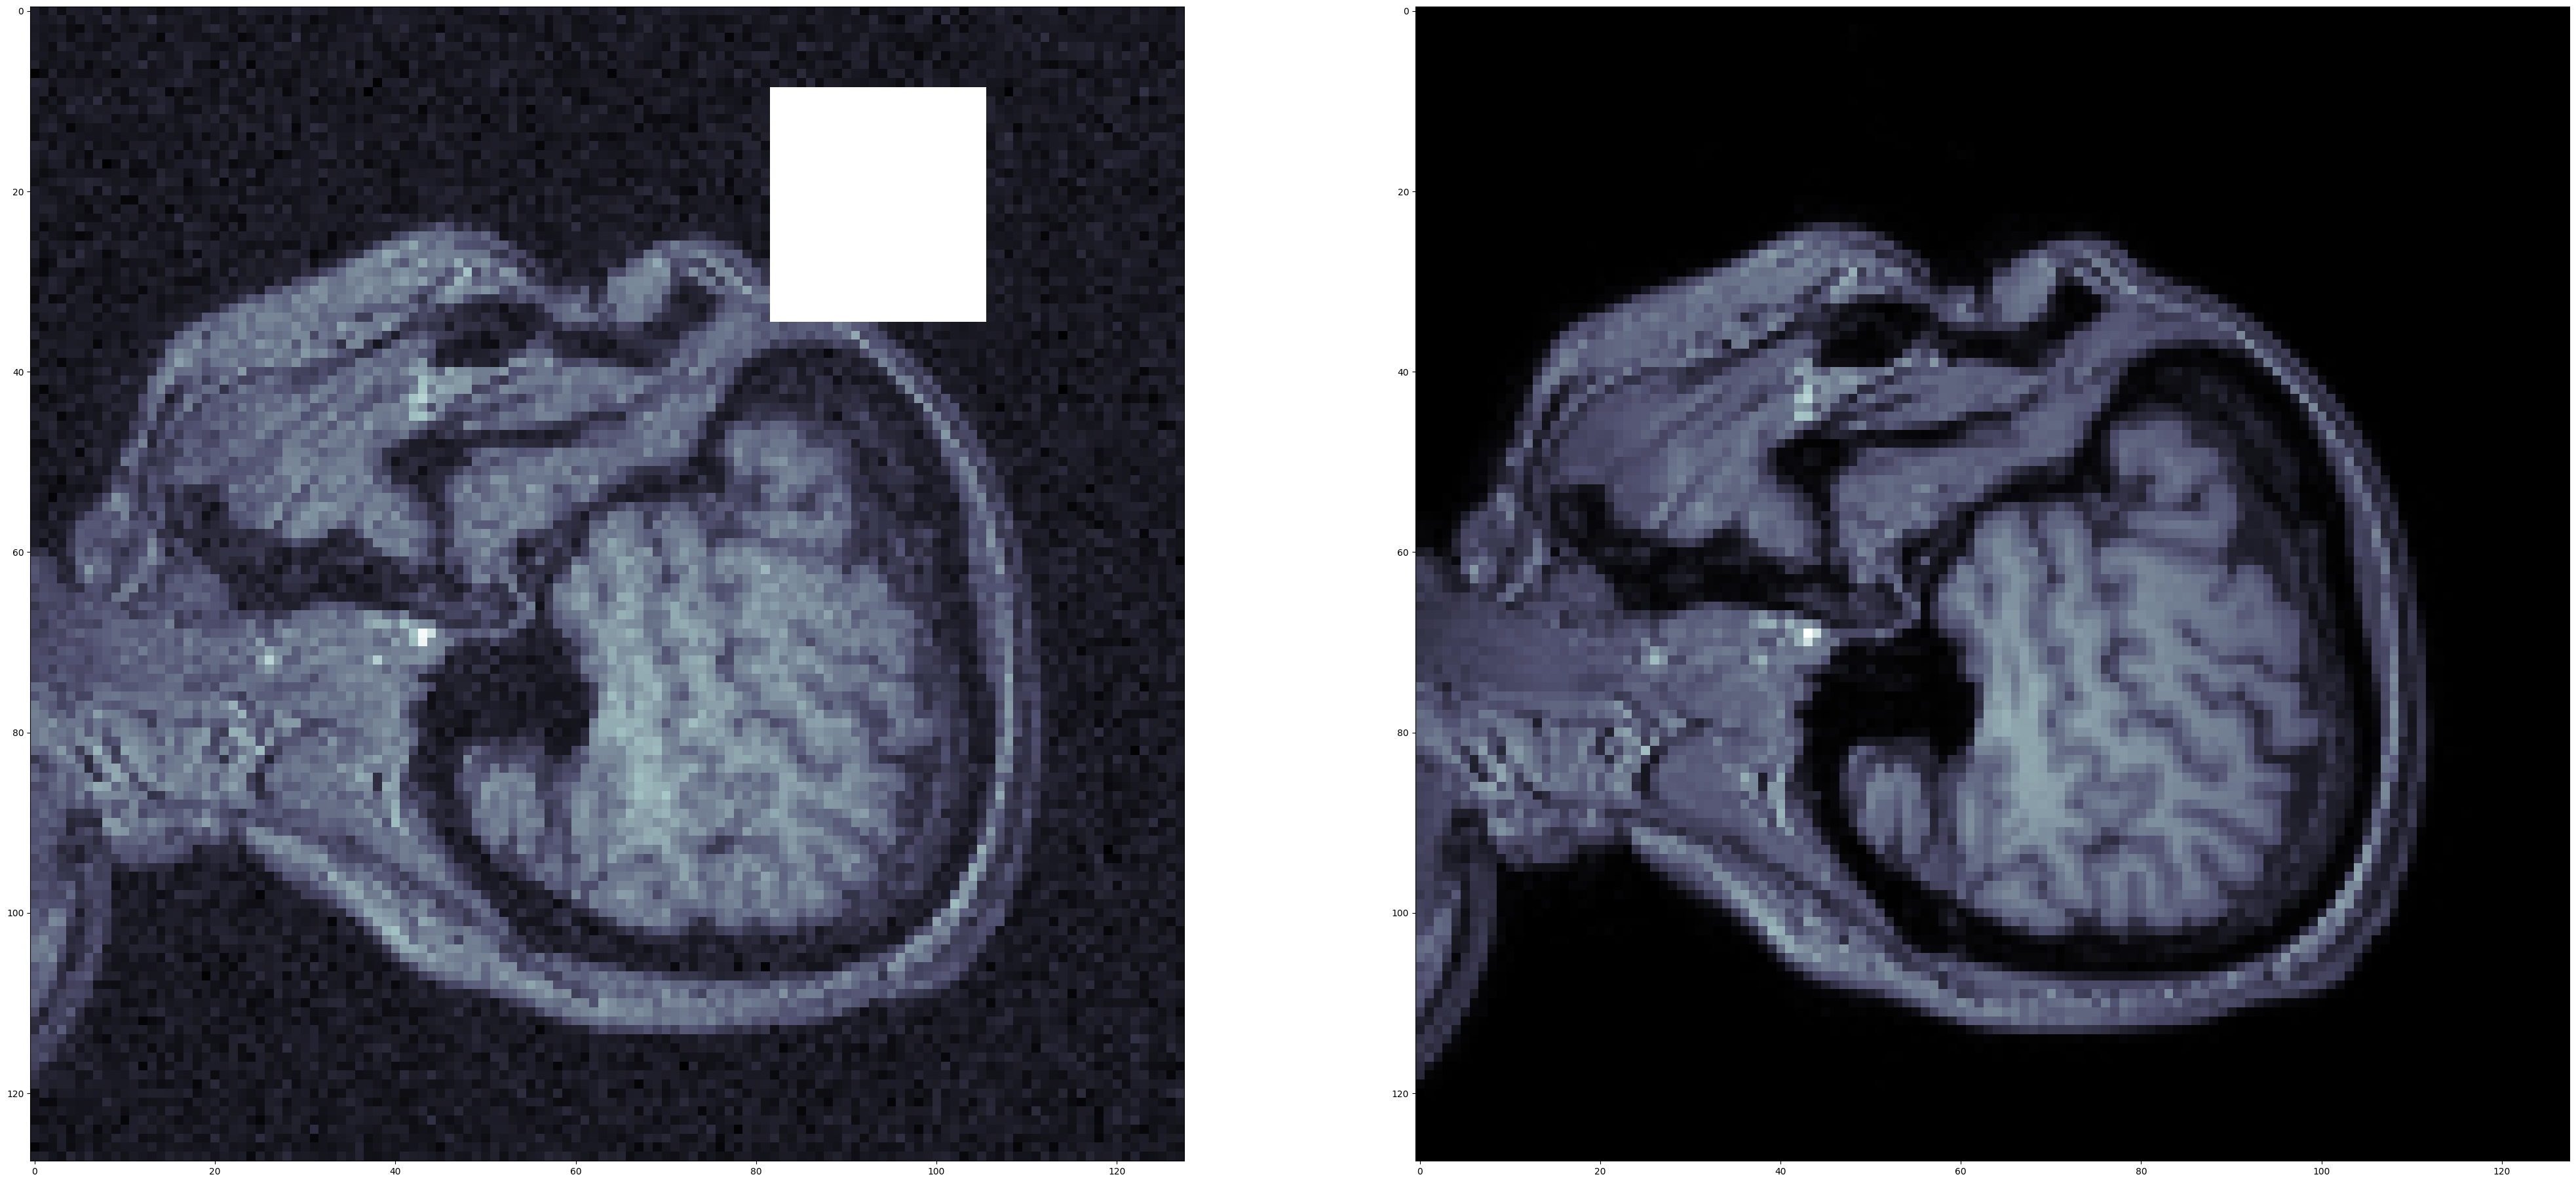

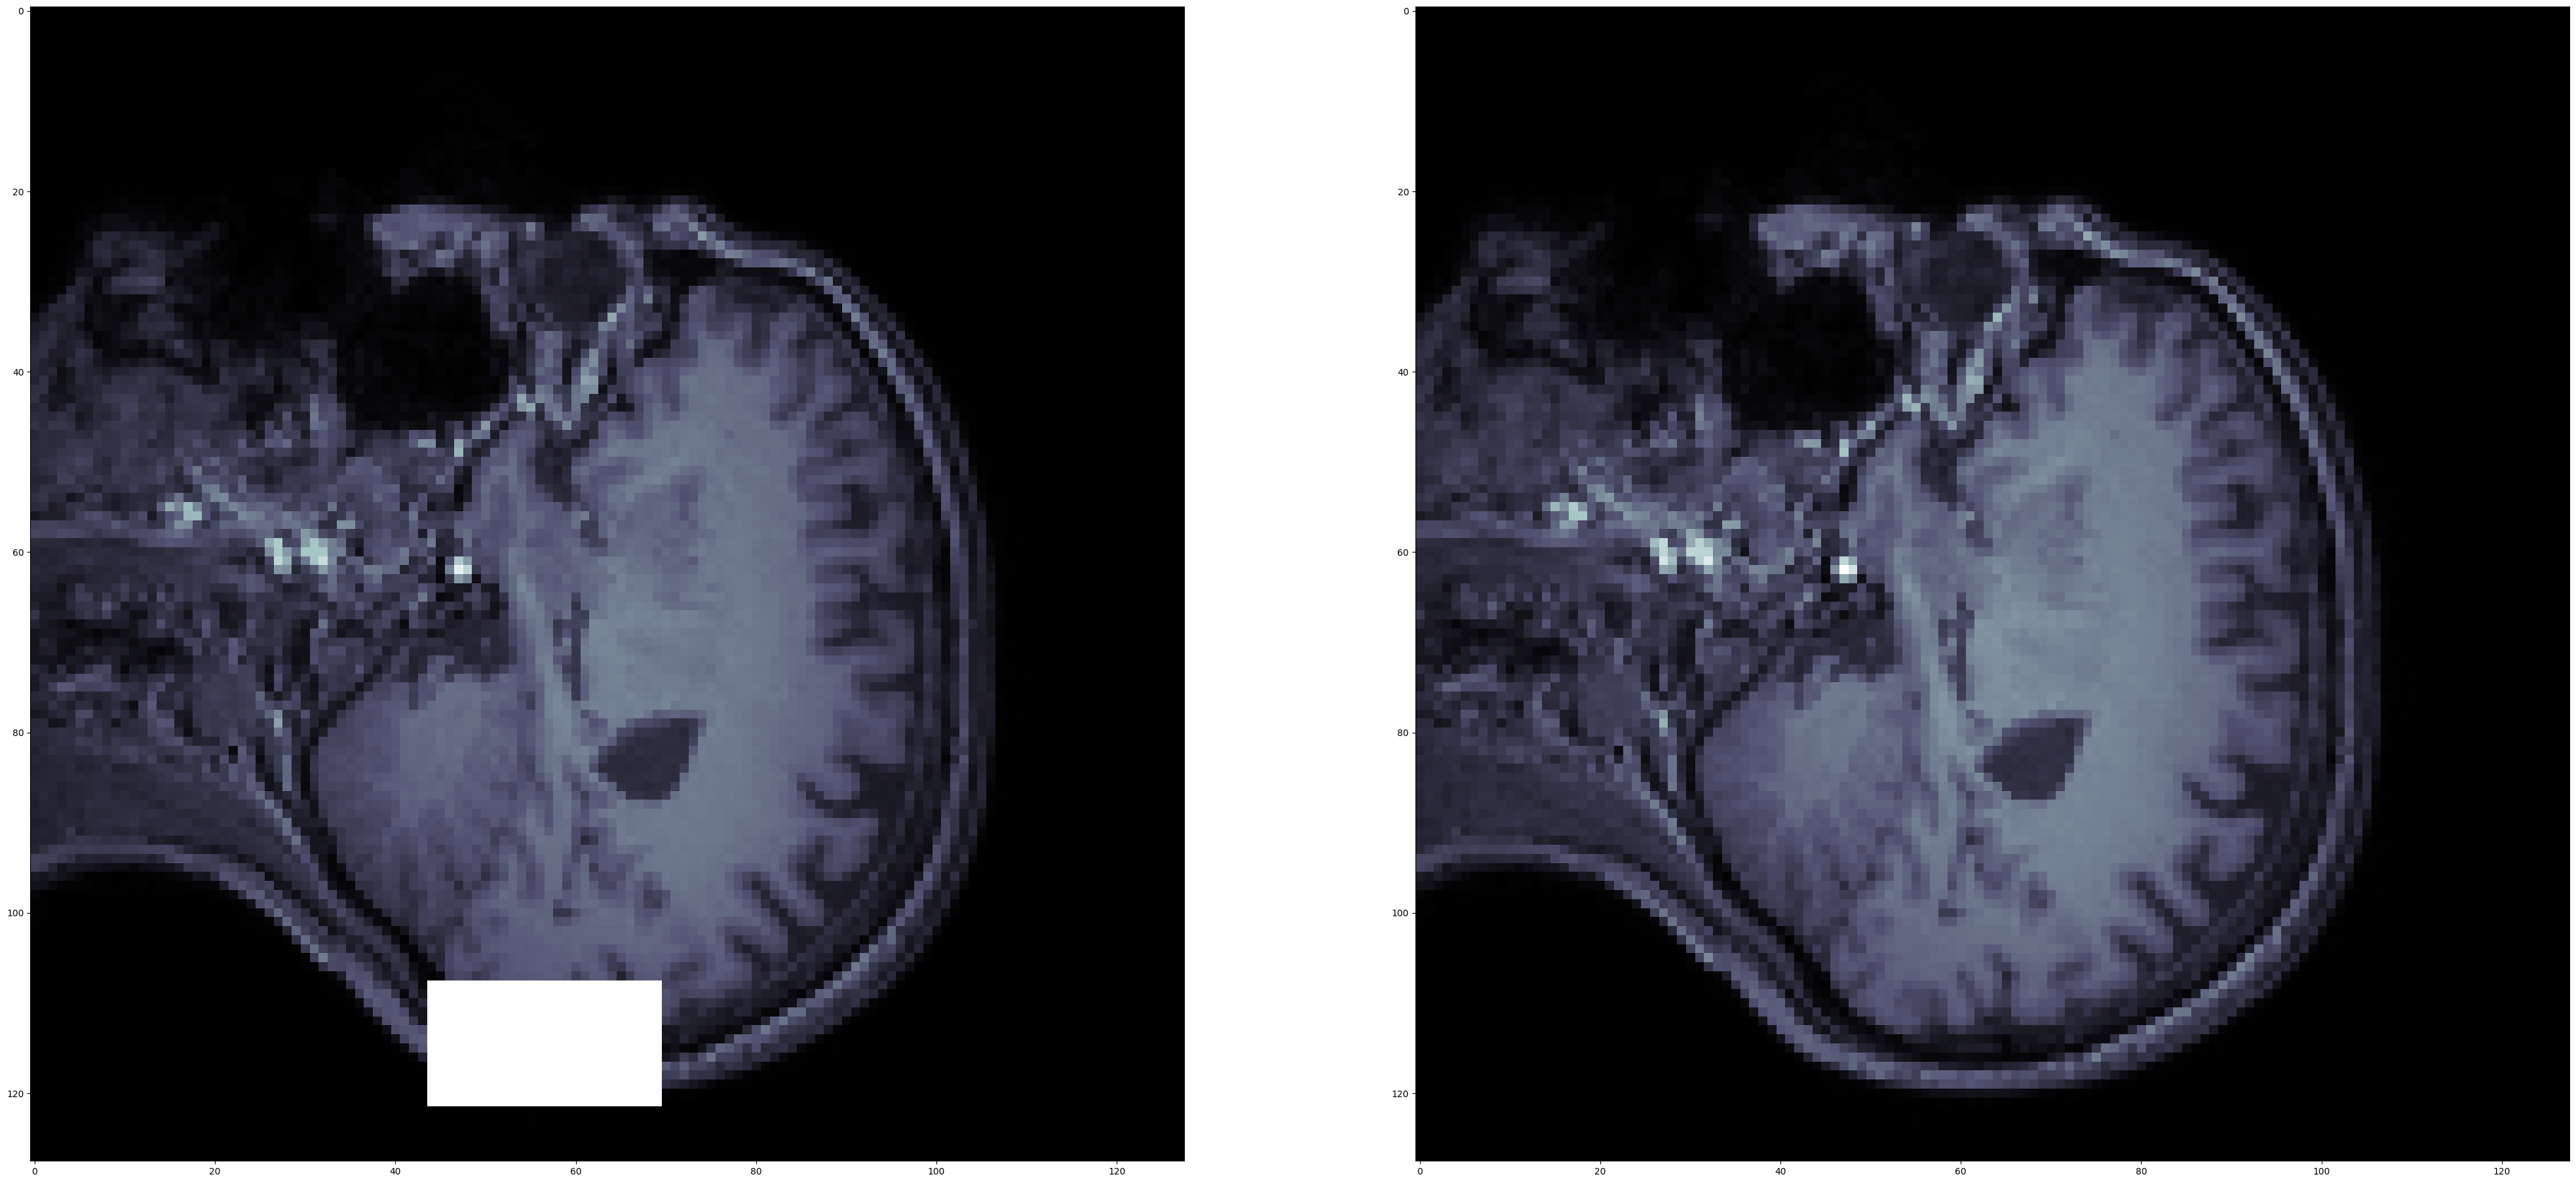

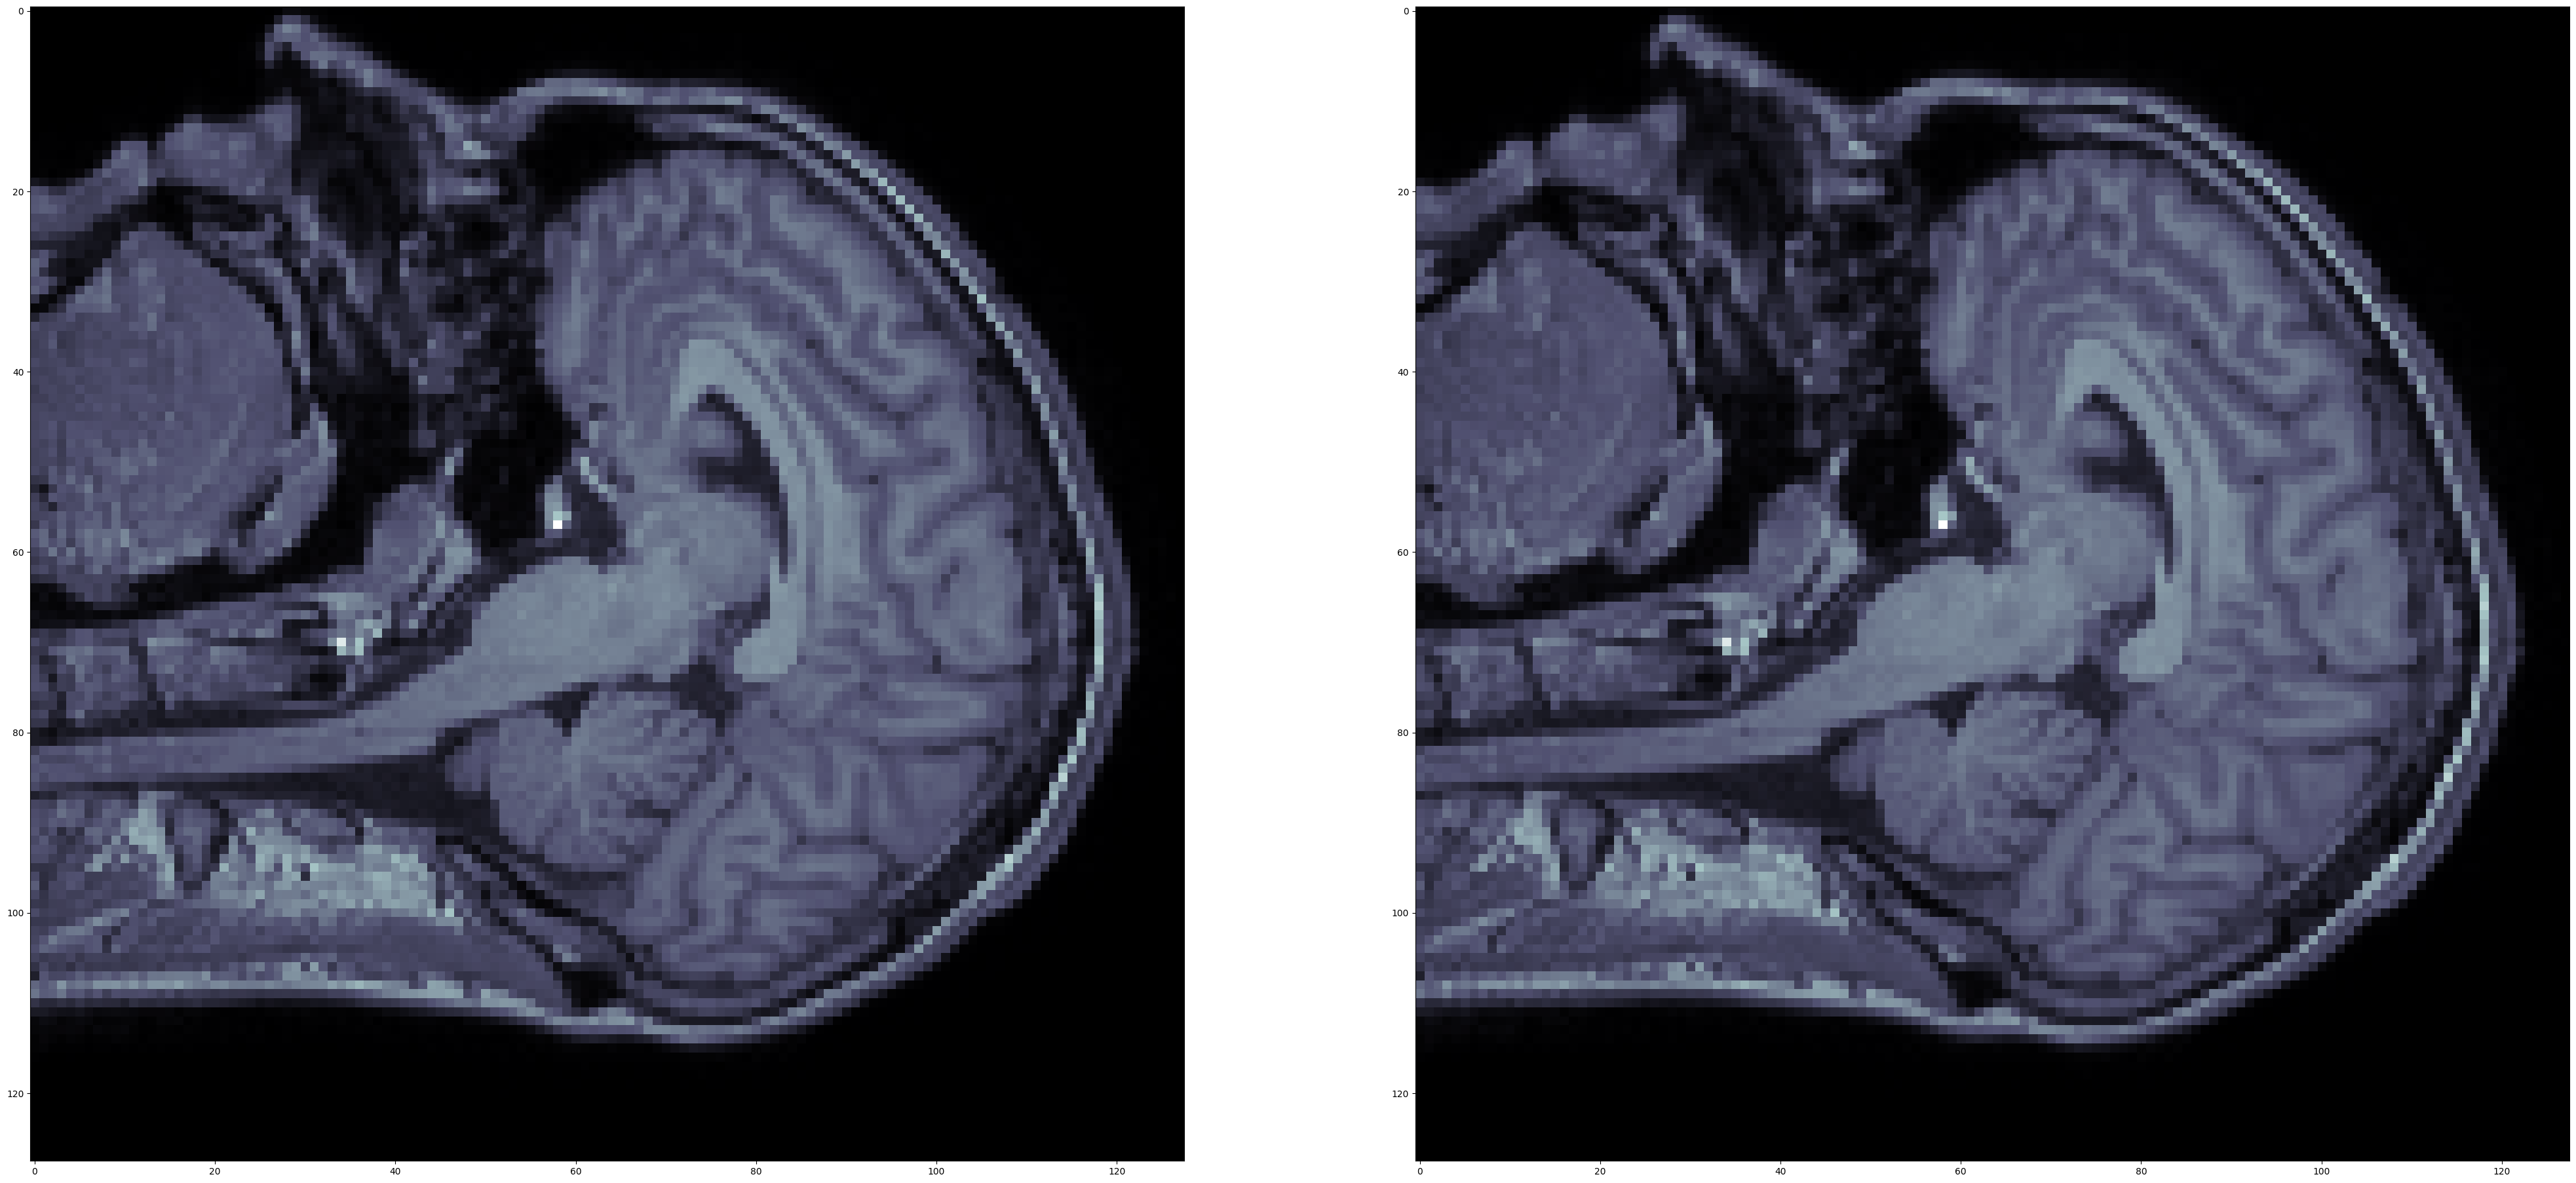

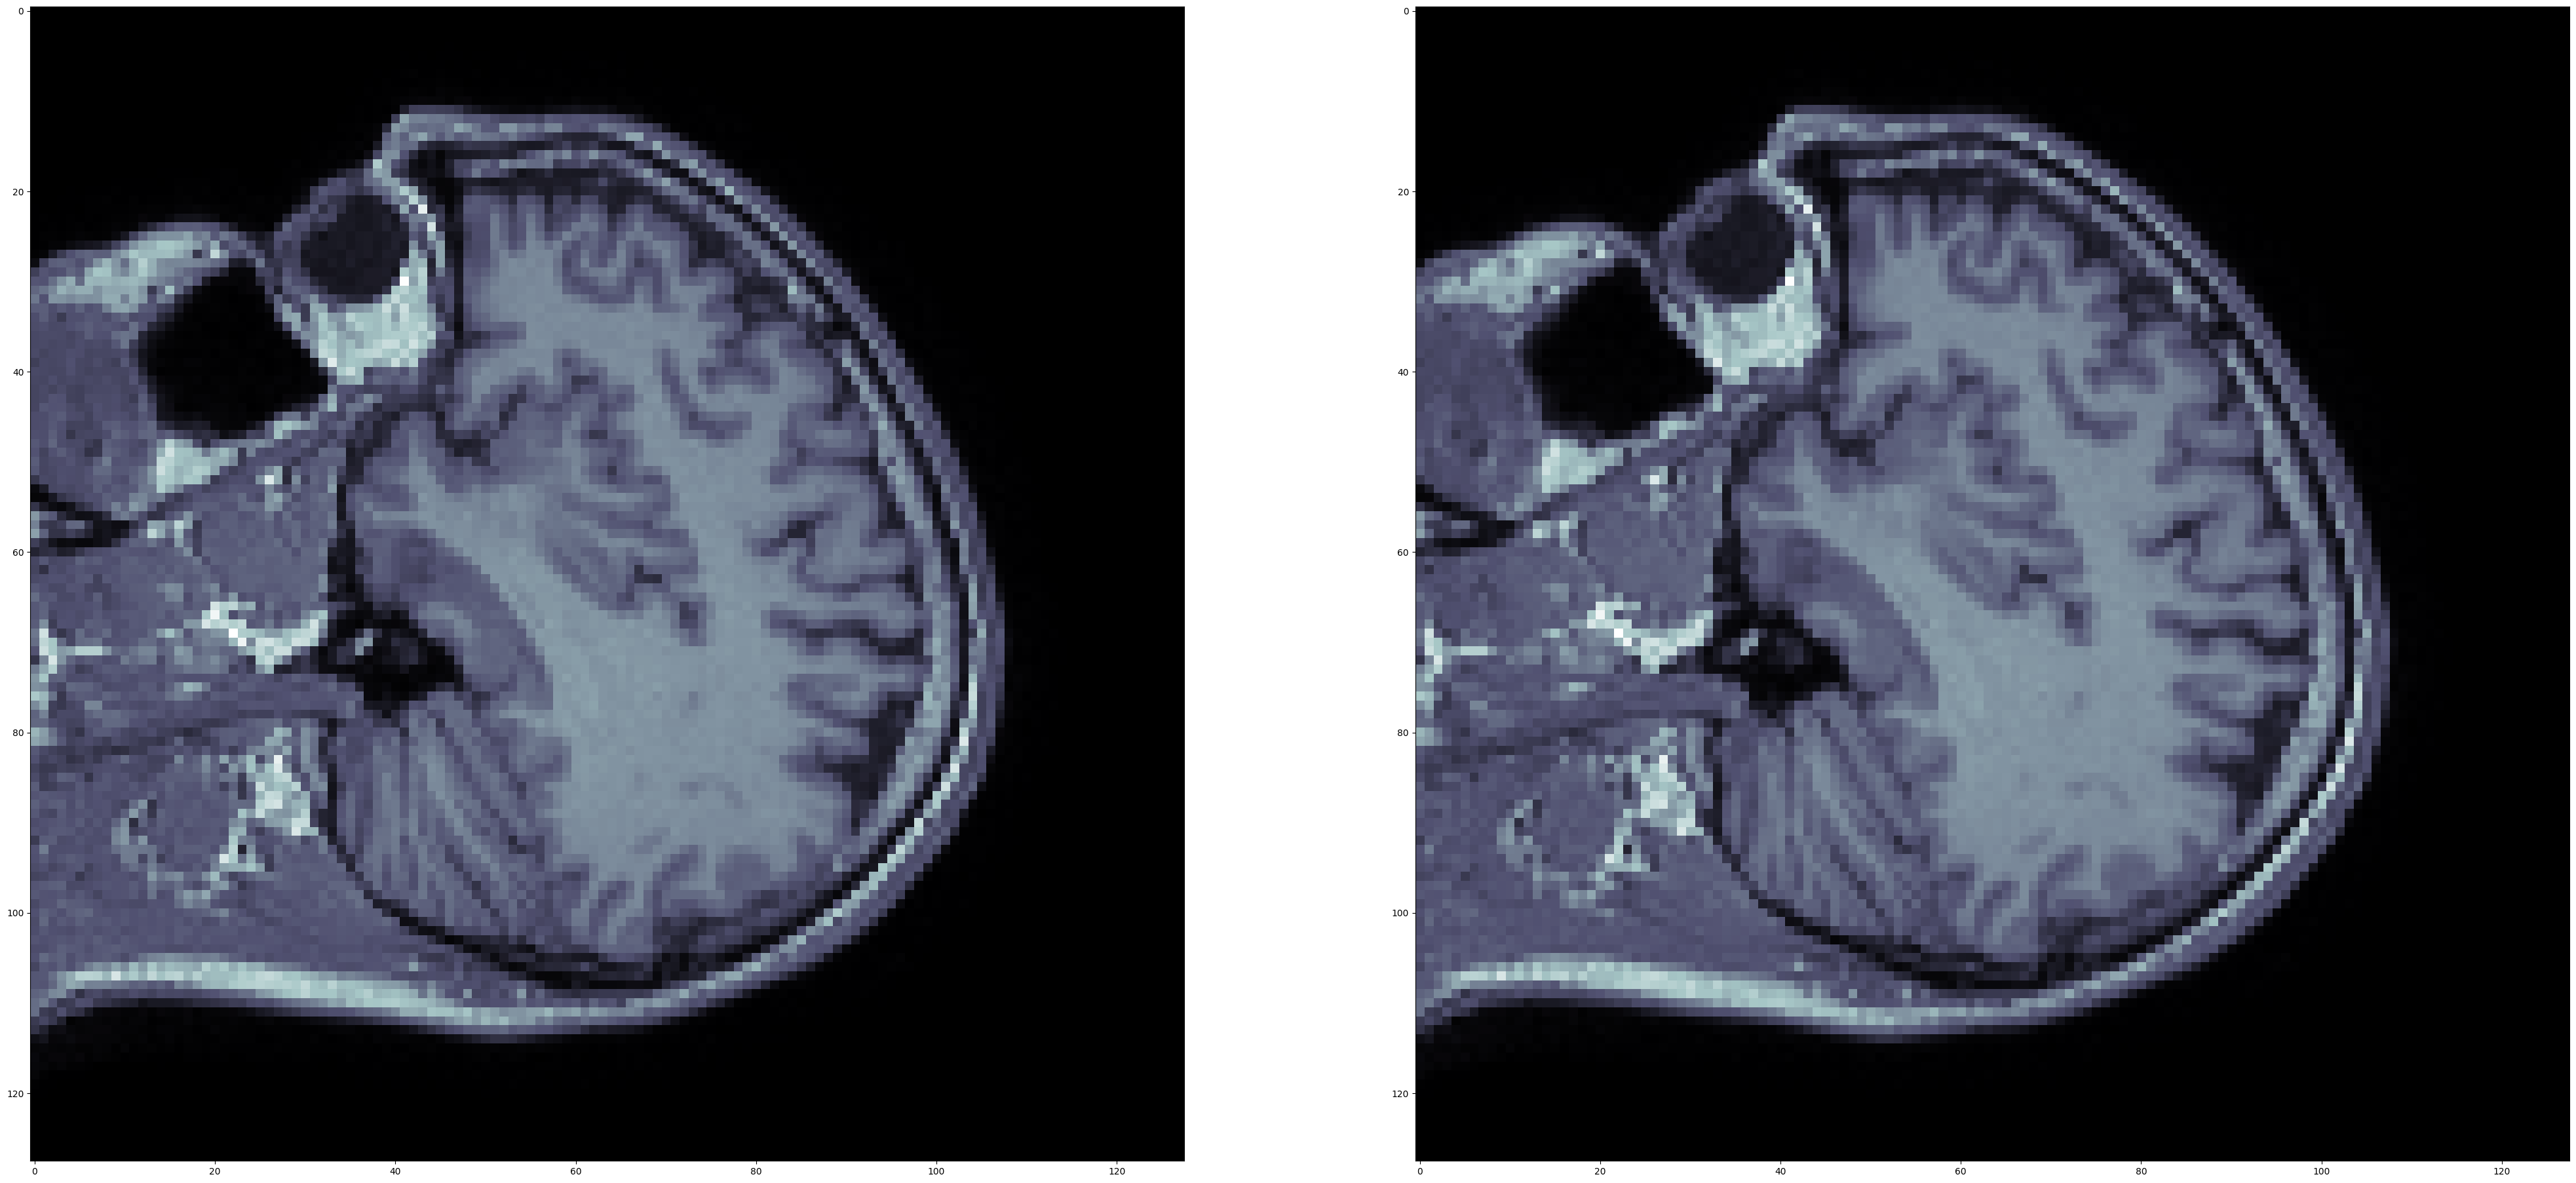

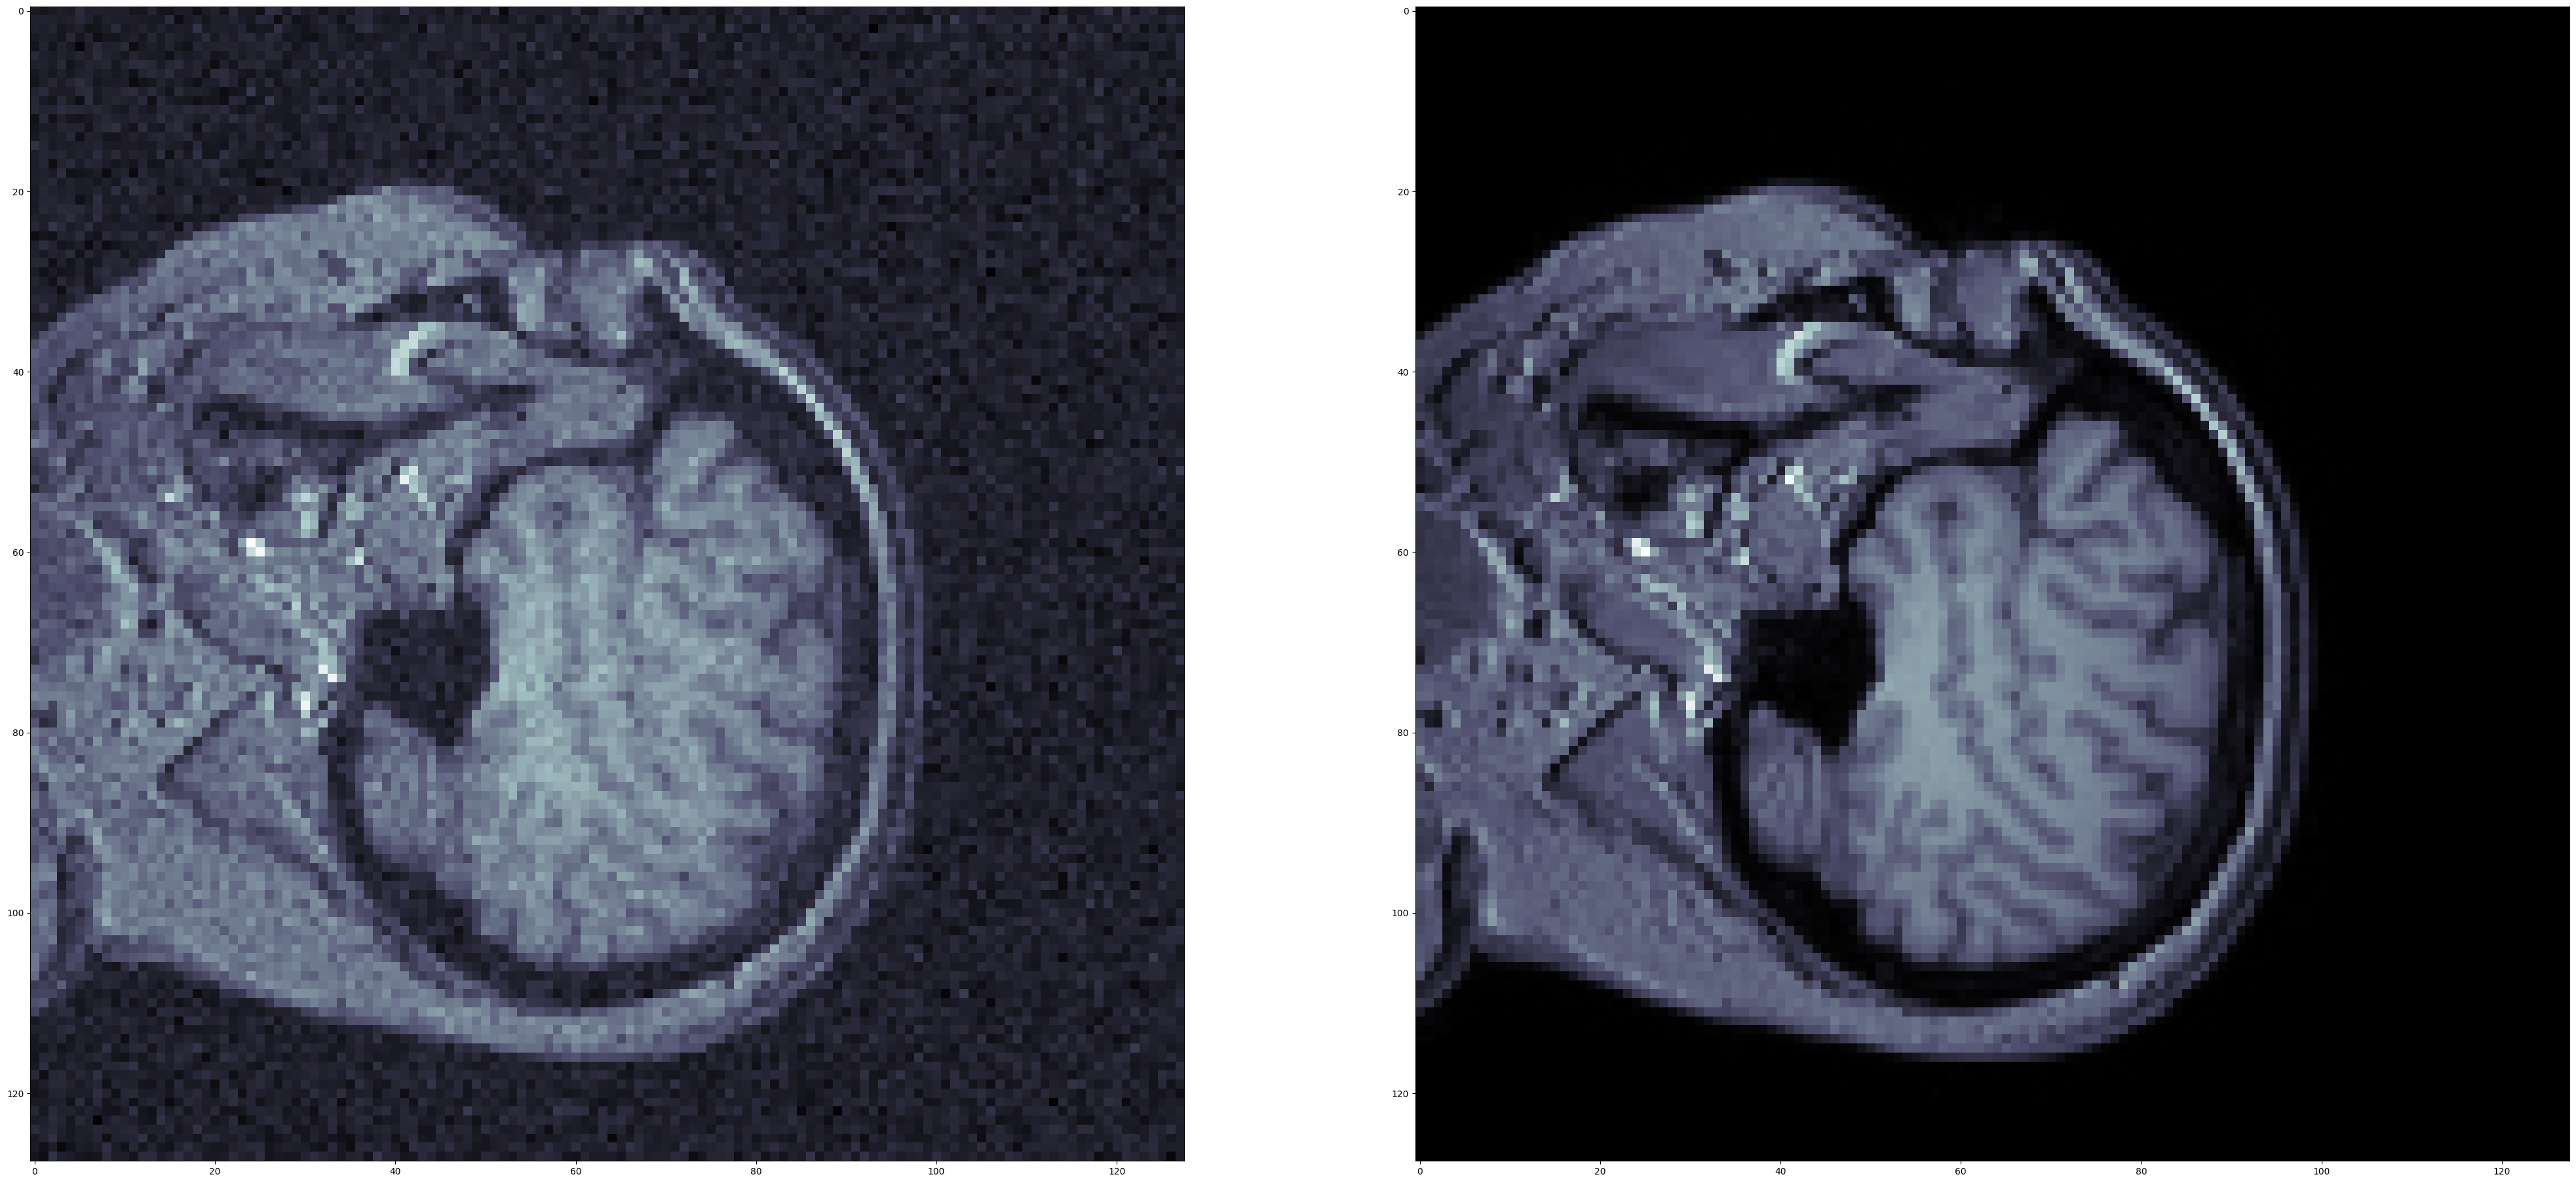

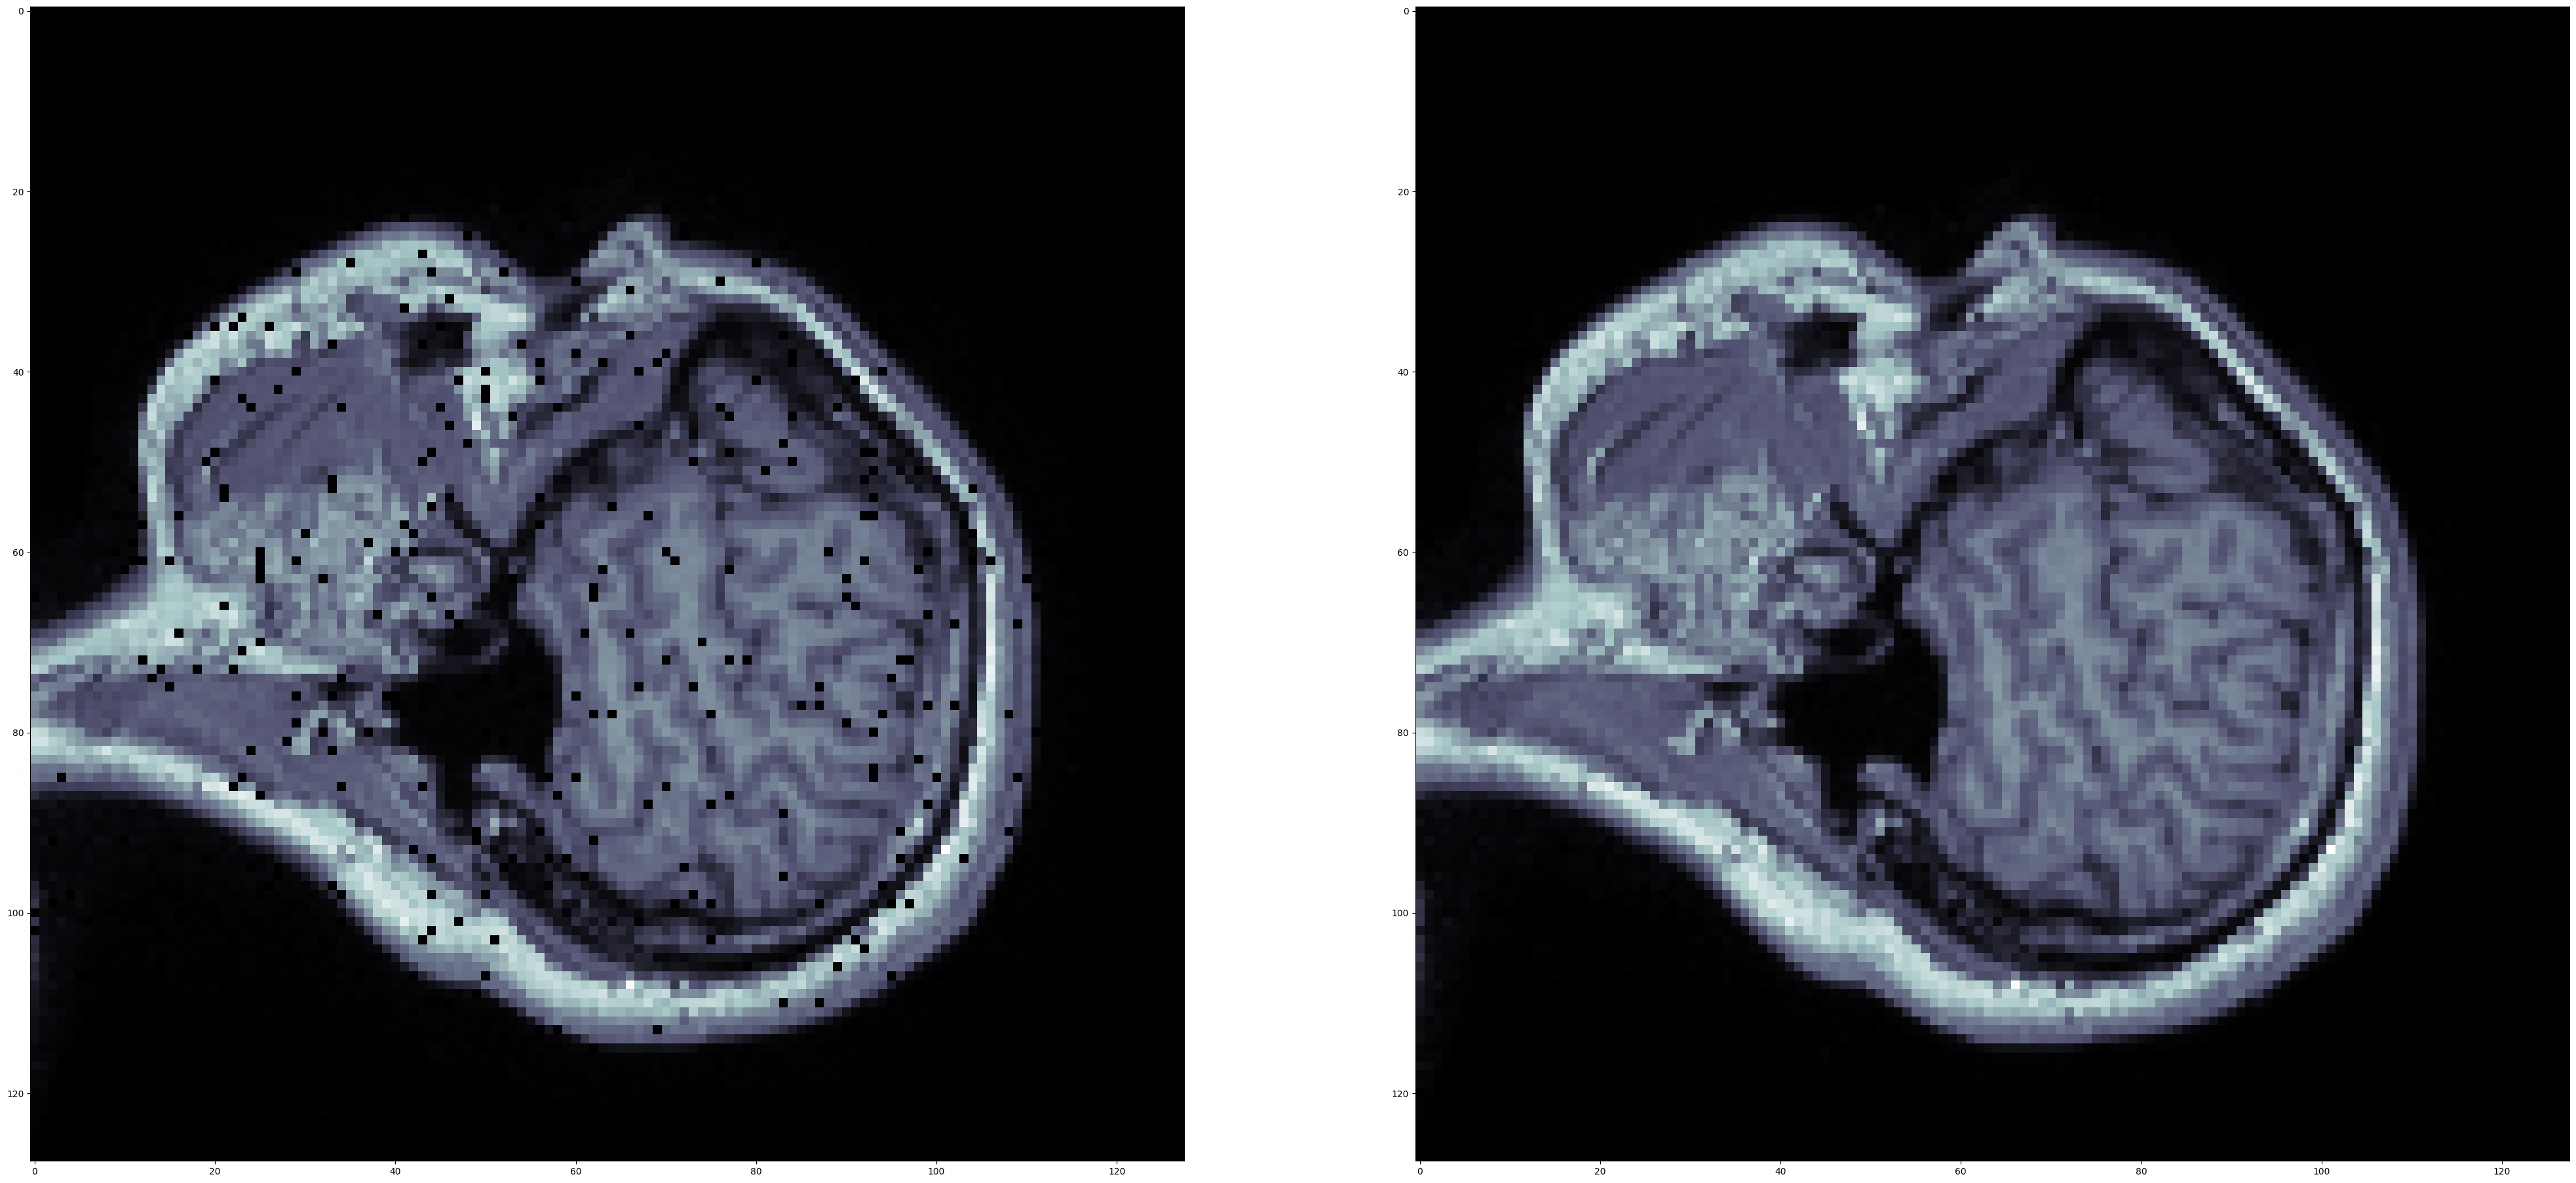

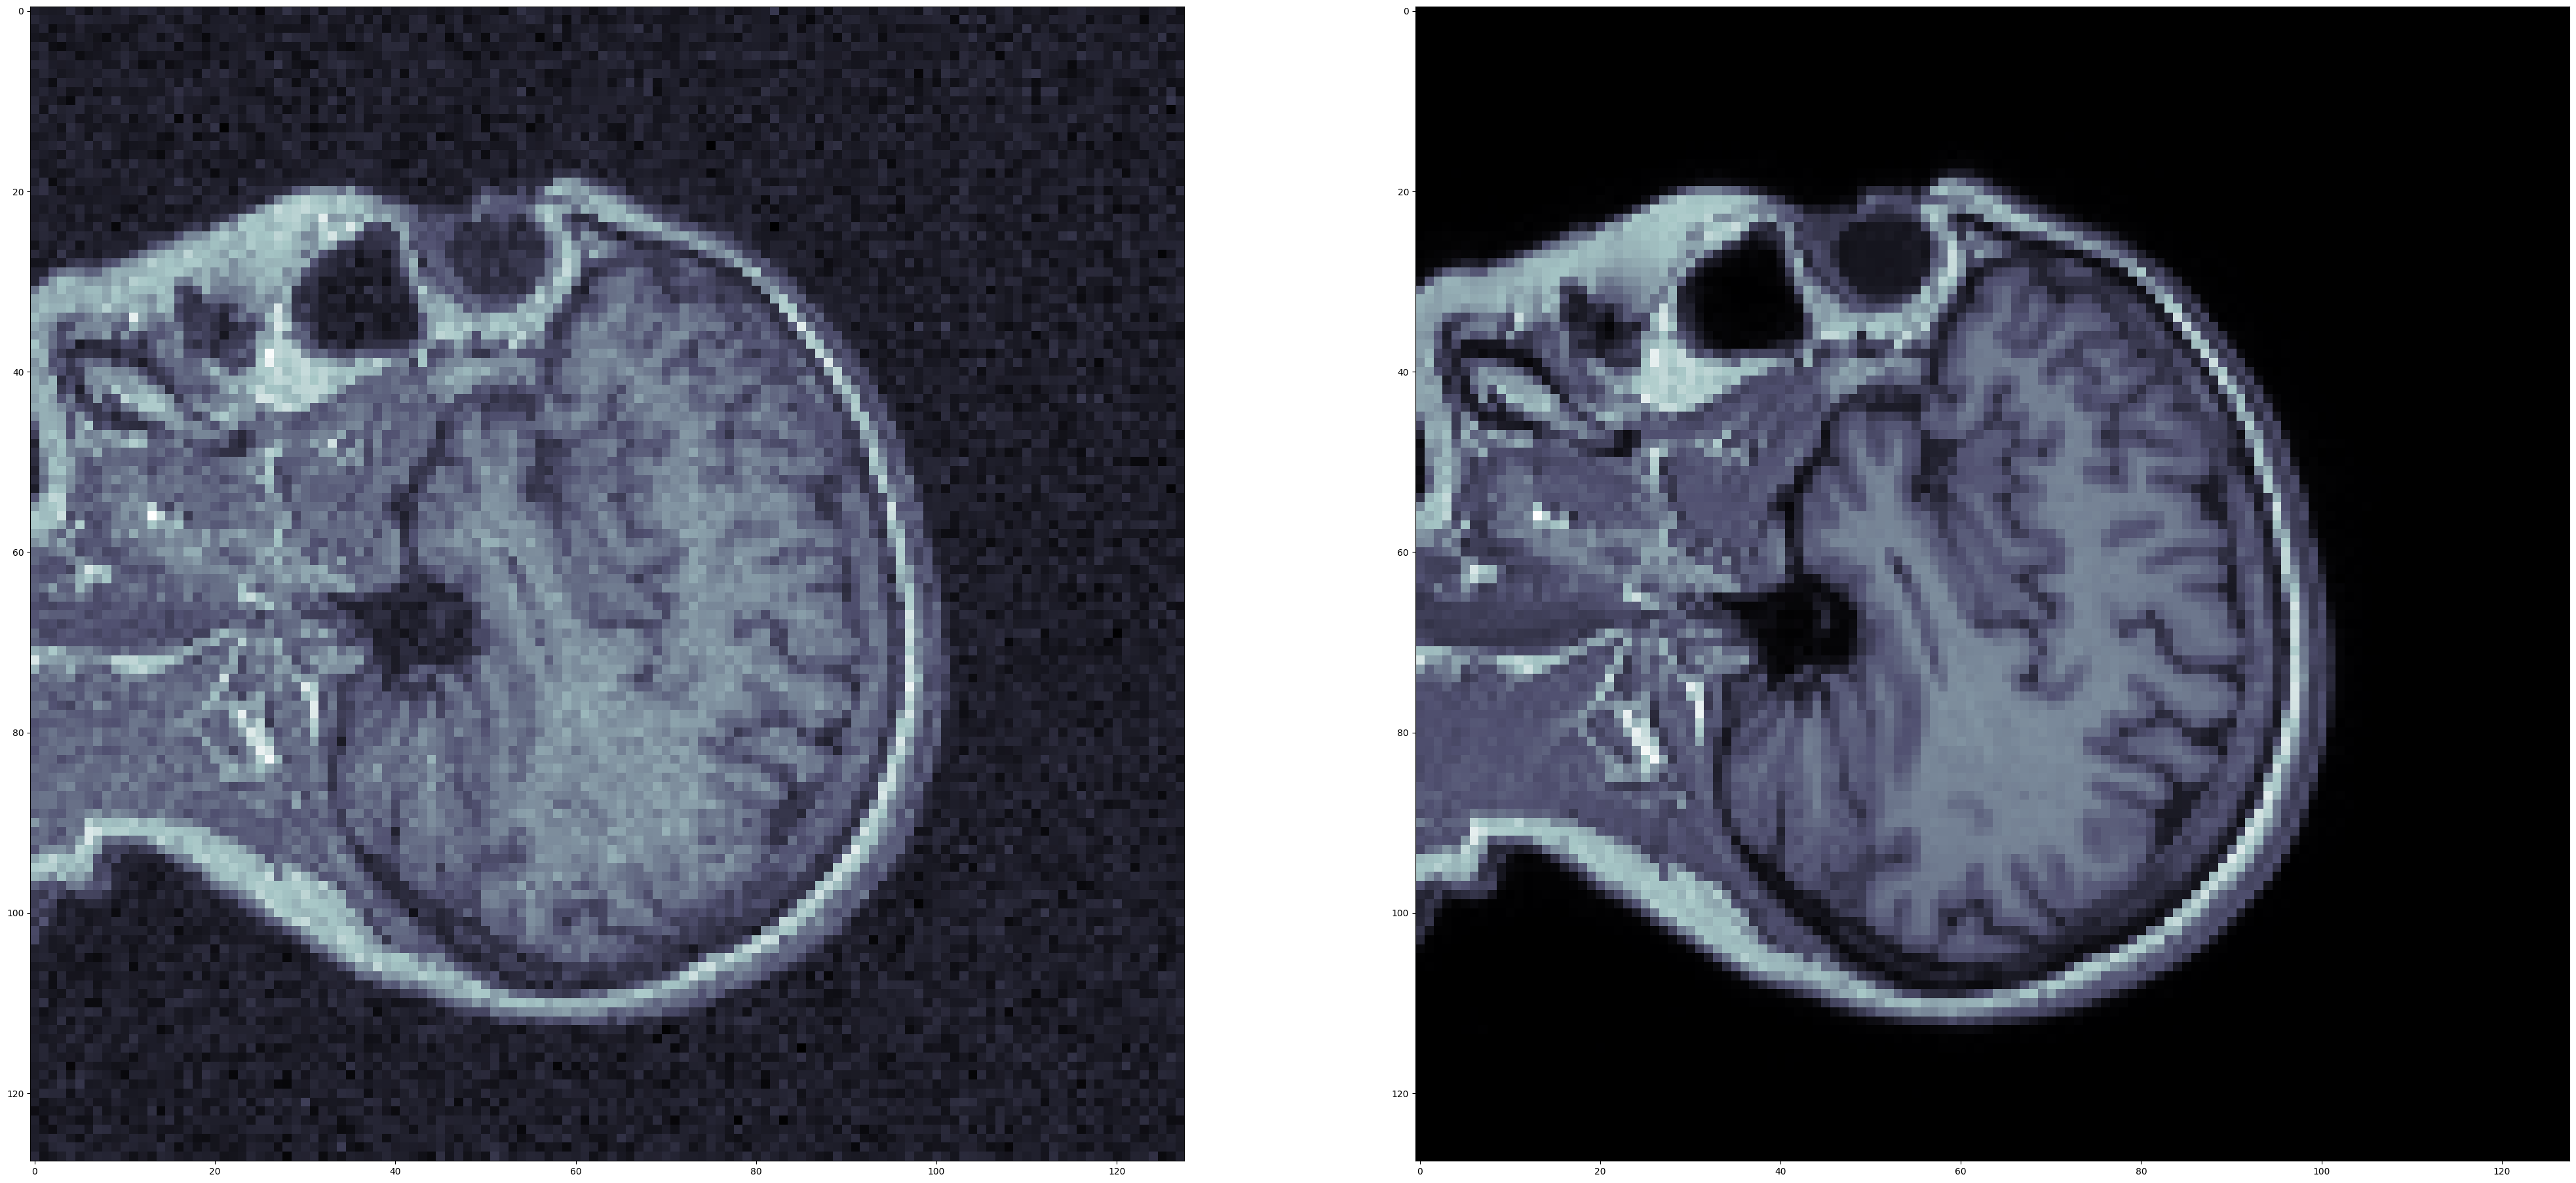

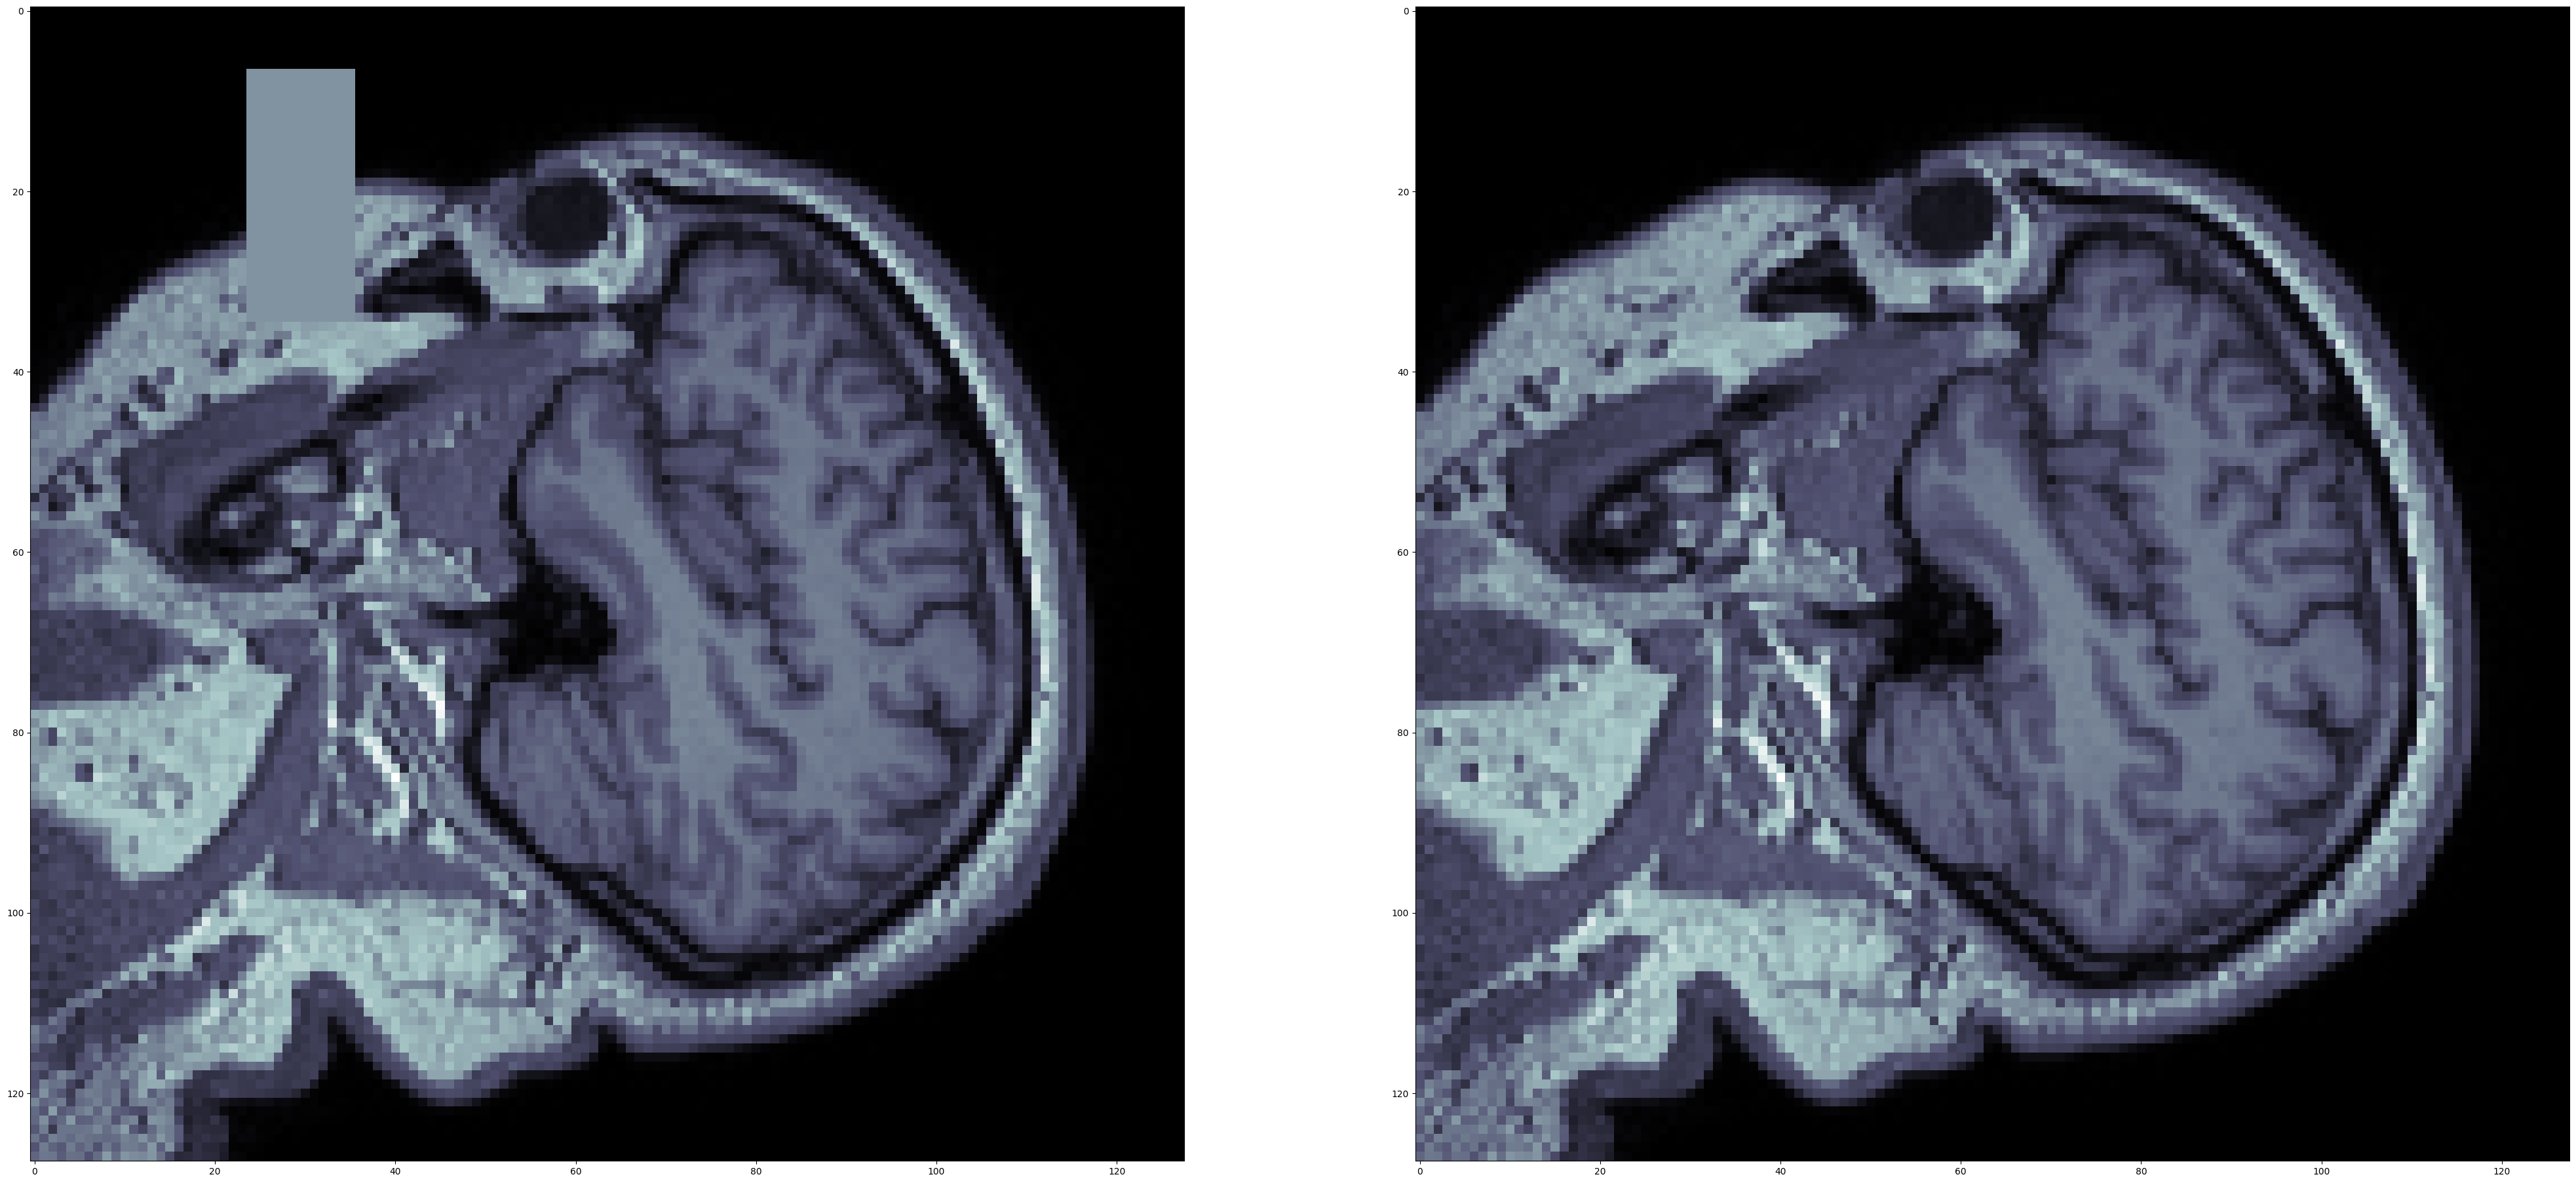

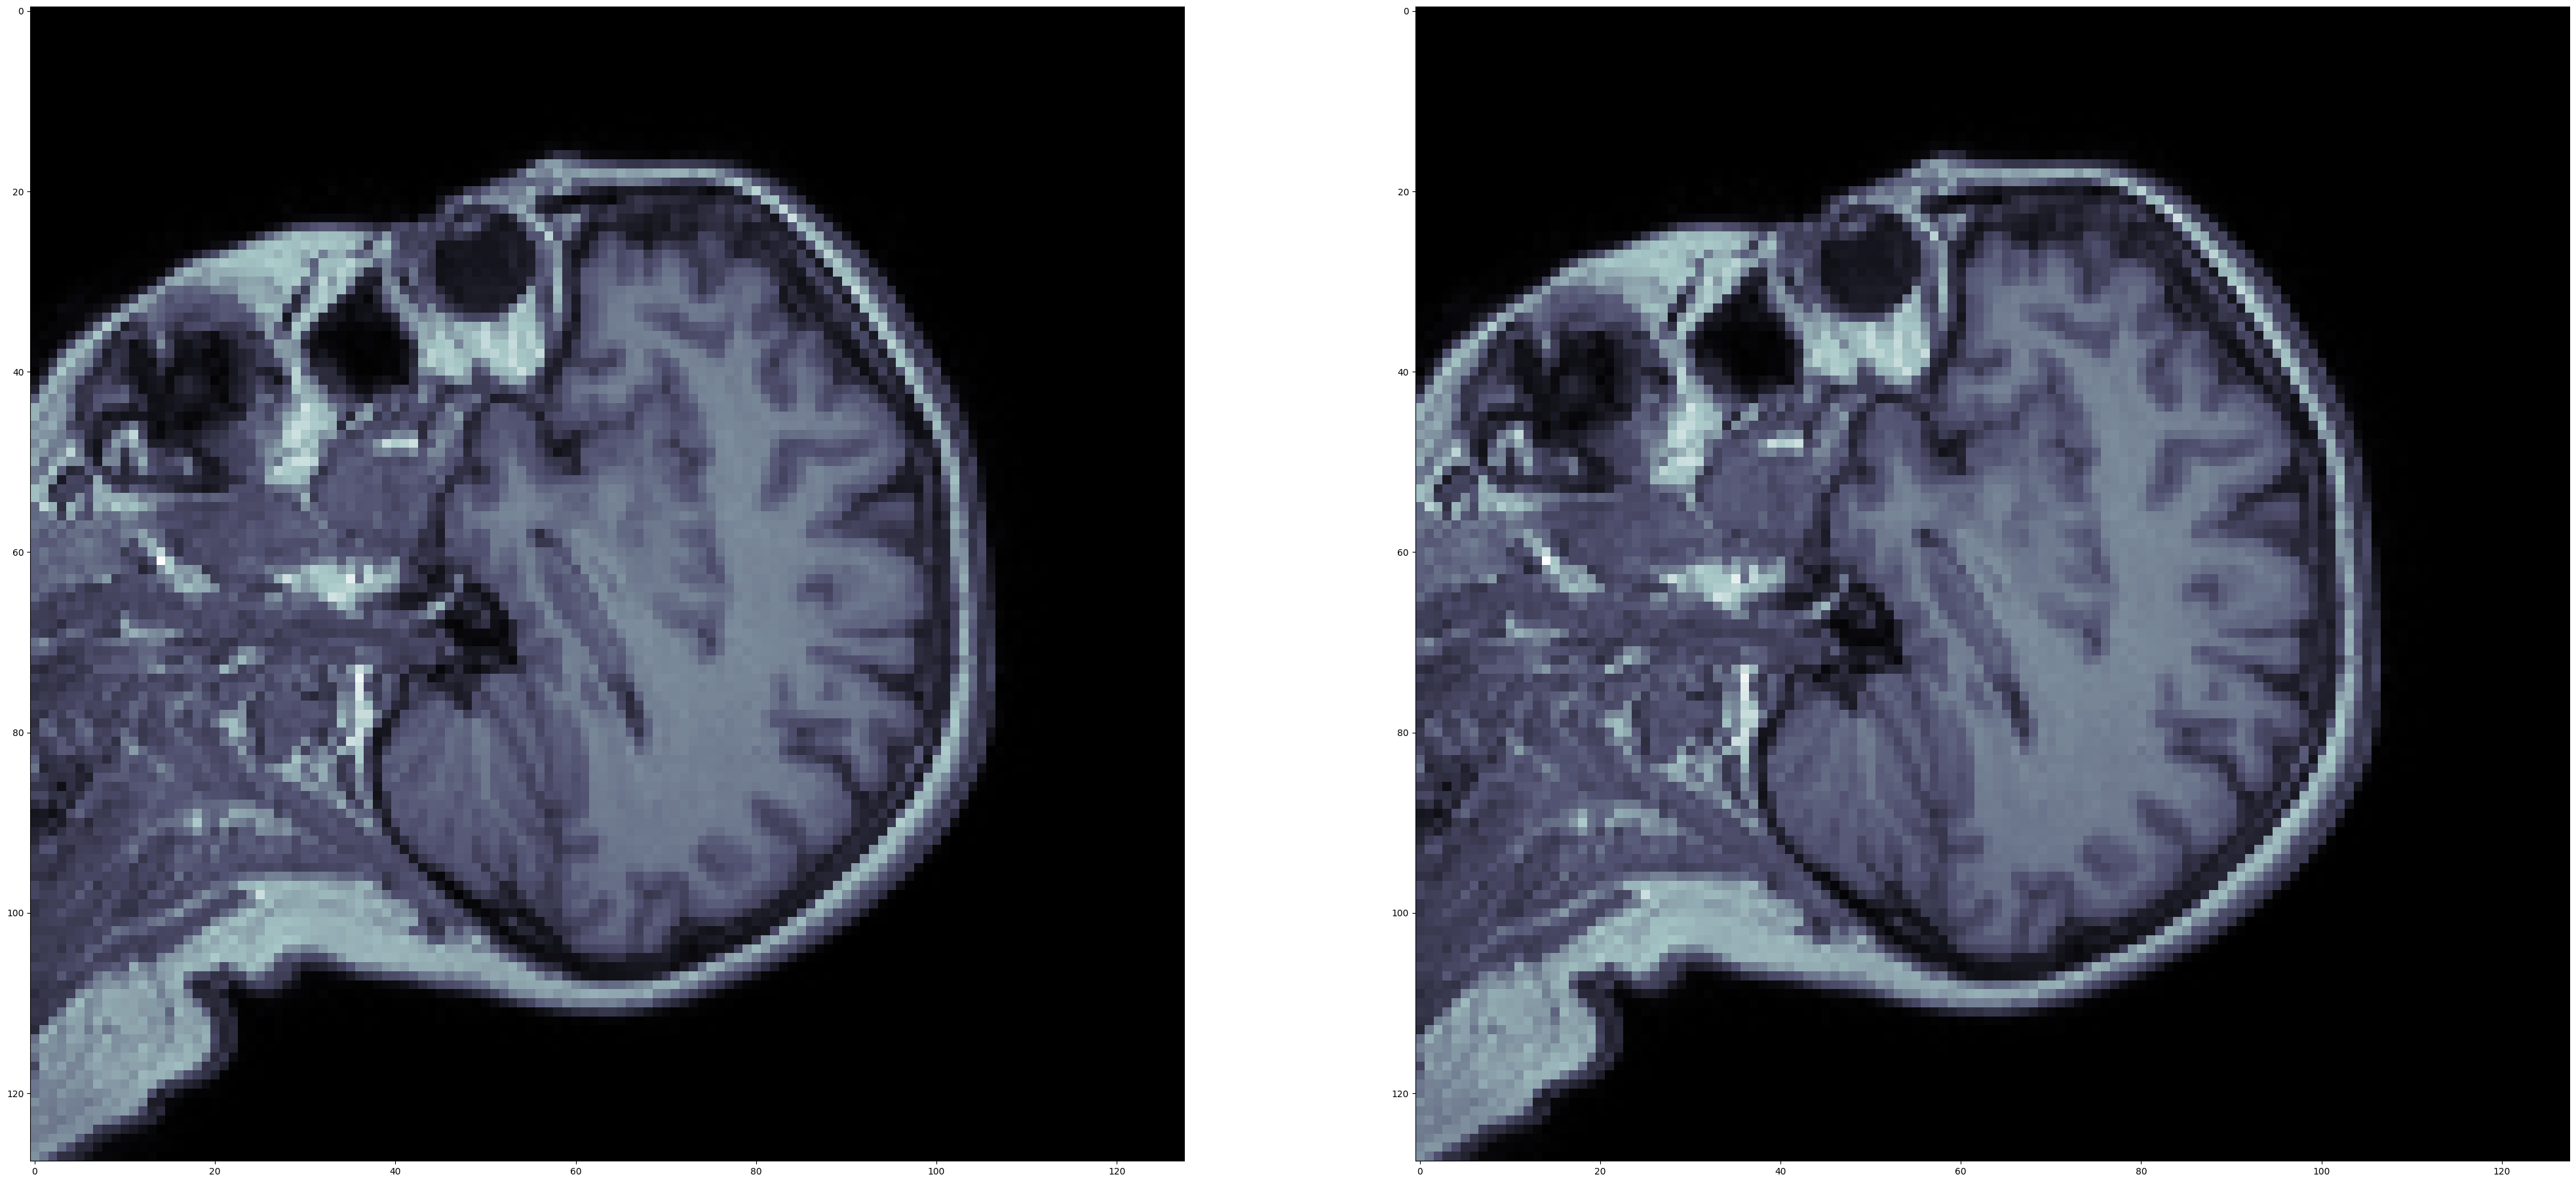

In [13]:
for batch in createDataset(train_files, BATCH_SIZE, shuffle=True, augment=True, sample=16*10):
    augmented = batch[0]
    groundtruth = batch[1]

    fig, ax1 = plt.subplots(1, 2, figsize = (50, 50))
    ax1[0].imshow(augmented[0], cmap ='bone')
    ax1[1].imshow(groundtruth[0], cmap ='bone')
    plt.show()
